In [241]:
import tensorflow as tf
import numpy as np

Prepare MNIST Dataset

In [242]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [243]:
# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

Create your batch of triplets

In [244]:
# describe this cell

def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 28, 28, 1))
    x_positives = np.zeros((batch_size, 28, 28, 1))
    x_negatives = np.zeros((batch_size, 28, 28, 1))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = np.random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[np.random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[np.random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]
print(create_batch()[2].shape)

(256, 28, 28, 1)


Plot your MNIST triplets

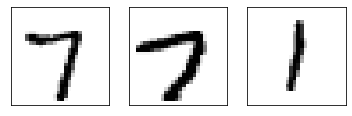

In [245]:
import matplotlib.pyplot as plt

def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

examples = create_batch(1)
plot_triplets(examples)

Implement your embedding model. Use Dense layer with emb_size as nuber of neurons and sigmoid activation function as last layer.

In [246]:
from tensorflow import keras
emb_size = 32
layer_1 = keras.layers.Input(shape=(28, 28, 1), name="layer_1")
layer_2 = keras.layers.Dense(128, activation='relu', name="layer_2")(layer_1)
layer_3 = keras.layers.Dense(64, activation='relu', name="layer_3")(layer_2)
output = keras.layers.Dense(emb_size, activation='sigmoid', name="layer_4_output")(layer_3)


In [247]:
model = keras.Model(inputs=layer_1, outputs=output) #Your Model (get an image, return a vector of size emb_size)#
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
layer_2 (Dense)              (None, 28, 28, 128)       256       
_________________________________________________________________
layer_3 (Dense)              (None, 28, 28, 64)        8256      
_________________________________________________________________
layer_4_output (Dense)       (None, 28, 28, 32)        2080      
Total params: 10,592
Trainable params: 10,592
Non-trainable params: 0
_________________________________________________________________


Check your embedding predictions.

In [248]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = model.predict(example)[0]

print(example_emb)

[[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 ...

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0

Implement Siamese network



In [249]:
# describe this cell

input_anchor = tf.keras.layers.Input(shape=(28, 28, 1), name="anchor")
input_positive = tf.keras.layers.Input(shape=(28, 28, 1), name="positive")
input_negative = tf.keras.layers.Input(shape=(28, 28, 1), name="negetive")

embedding_anchor = model(input_anchor)
embedding_positive = model(input_positive)
embedding_negative = model(input_negative)

# concat just in axis=1.
output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1, name="output")

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output, name="net")
net.summary()

Model: "net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negetive (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model_26 (Functional)           (None, 28, 28, 32)   10592       anchor[0][0]                     
                                                                 positive[0][0]                 

We use PCA for showing embeddings in two dimenshion. **Don't change it**.

In [250]:
# describe this cell

from sklearn.decomposition import PCA

class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(15, 4))
        self.ax1 = plt.subplot(1, 3, 1)
        self.ax2 = plt.subplot(1, 3, 2)
        self.ax3 = plt.subplot(1, 3, 3)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        pca_out = PCA(n_components=2).fit_transform(self.x_test.reshape((self.x_test.shape[0], 28*28)))
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')

        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax2.clear()
        self.ax2.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')

        if plot_loss:
            self.ax3.clear()
            self.ax3.plot(range(epoch), self.losses)
            self.ax3.set_xlabel('Epochs')
            self.ax3.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

Implement triplet_loss with tensorflow useful functions based on what you learned in class 

In [251]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

Data generator

In [252]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

Analyze your results.

ValueError: ignored

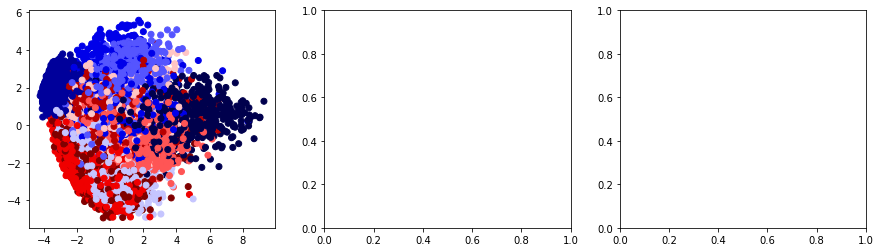

In [254]:
batch_size = 1024
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')
# x_test = x_test.reshape(10000, 784)
net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=1,
    callbacks=[PCAPlotter(model, x_test[:10000], y_test[:10000])]
    )